# Classification of Digits

## Load the Data

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
mnist.keys() # show keys

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape # See size of feature

(70000, 784)

In [3]:
y.shape

(70000,)

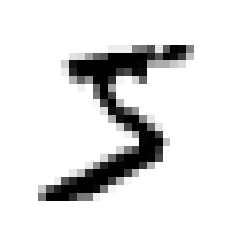

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# take a look at the first digit (Each digit has 28x28 pixels)
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0] # label is 5
y = y.astype(np.uint8)

### Before inspecting the data, create training and test set

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Create Binary classifier for digit 5 

In [7]:
y_train_5 = (y_train == 5) # True if digit is 5, false otherwise
y_test_5 = (y_test == 5)

In [8]:
# import Stochastic Gradient Descend (SGD) Classifier and train it
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
# use classifier to predict number 5
sgd_clf.predict([some_digit])

array([ True])

### Implement Cross Validation for Performance measure

In [9]:
# Instead of using "cross_val_score()" we can implement cross-validation by ourself, if we need more freedom
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # make a copy 
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds) #train on train-validation-part
    y_pred = clone_clf.predict(X_test_fold) # predict outcome on test-validation-part
    n_correct = sum(y_pred == y_test_fold) # compare prediction with actual result
    print(n_correct / len(y_pred))

/Users/david/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [10]:
# using mentioned function corss-val-score(), which does the same than code above
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Confusion Matrix

In [11]:
#Better way to evaluate performance is application of confusion matrix
from sklearn.model_selection import cross_val_predict 
#Get set pf predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
# Another scikit function to compute classifier metrics
from sklearn.metrics import precision_score, recall_score 
precision_score(y_train_5, y_train_pred) # 3530 / (3530+687) #83% right when model claims to see a 5 -->precision

0.8370879772350012

In [14]:
recall_score(y_train_5, y_train_pred) # 3530 / (3530+1891) Only detects 65% of the 5's -->recall

0.6511713705958311

In [15]:
# Call f1-score() function for combination of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### More to Precision and Recall

In [16]:
# To investige the Threshold between precision and recall
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [17]:
# Use precision_recall_curve() to compute precision recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

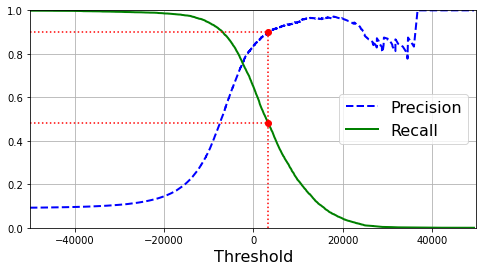

In [18]:
# Use matplotlib to plot results
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] #point recall at precision 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #lowest threshold point at precision 90%


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                       # Not shown
plt.show()

In [19]:
#make predictions
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [20]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC curve

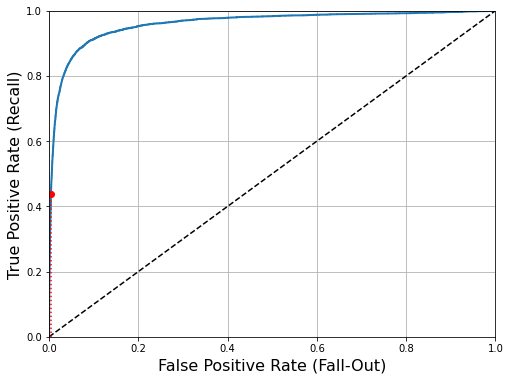

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")                                     
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

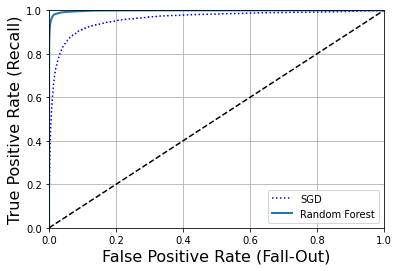

In [24]:
plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show() # Random forest superior to previous SGD classifier

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [26]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [27]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification

In [28]:
from sklearn.svm import SVC # vector machine classifier

svm_clf = SVC() #One-vs-One classifier by default
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [29]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [30]:
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.977 , 0.9738, 0.9739])

#### One vs the Rest Classifier

In [31]:
from sklearn.multiclass import OneVsRestClassifier # force OVR method

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])
some_digit_score = ovr_clf.decision_function([some_digit])
some_digit_score

array([[-1.34386   , -1.51948026, -1.22096067, -0.92938037, -2.00572727,
         0.6077433 , -1.62258907, -0.99975597, -1.2763794 , -1.70311184]])

In [32]:
### SGD Classifier is just as easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [33]:
### Evaluating SGD classifier using cross_val_score()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [34]:
## Scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # Scaling inputs lead to higer accuracy

array([0.8983, 0.891 , 0.9018])

### Trying to improve SGD Model

In [35]:
## Set up Confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

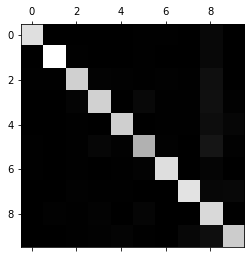

In [36]:
# look at image representation for better overview
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

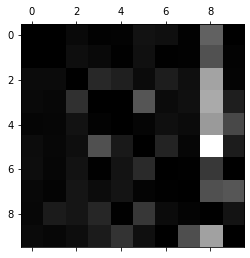

In [37]:
# Look at the relative error per class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# Fill diagonals with zeros and keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() 
# Plot tells us that al lot of numbers get false classified as 8's
# confusion matrix is not necessarily symmetrical, but it is obvious that 3'3 and 5's are interchanged 

## Multilabel Classification

In [39]:
# Classify digits into multiple groups (labels) - number >6 and odd numbers
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [40]:
knn_clf.predict([some_digit]) # Right prediction, number 5 is <7 and odd

array([[False,  True]])

In [41]:
# To evaluate, compute average F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [42]:
# Each label can have multiple outputs
# Task: blurry an image and clean this image again
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [44]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

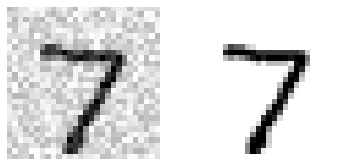

In [45]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

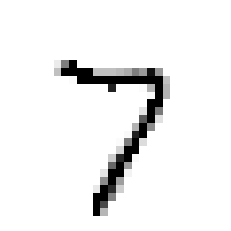

In [47]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

In [48]:
# Build classifier dataset for MNIST that achieves over 97% accuracy using KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights="distance", n_neighbors = 4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [49]:
y_knn_pred = knn_clf.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714